# 3D Medical Image Upscaling Pipeline

Upscale synthetic CT images generated by 3D Pix2Pix using various interpolation and deep learning methods.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from pathlib import Path
import time
from scipy.ndimage import zoom
from skimage.transform import resize
import SimpleITK as sitk

## 🧠 Load Original MR/CT(if training) File (Target Resolution)

In [3]:
# Paths to MR and CT files
mr_path = "/Users/samwallace/Documents/sCT/Comparison Pix2Pix/3D/datasets/overfit/mr.mha"
ct_path = "/Users/samwallace/Documents/sCT/Comparison Pix2Pix/3D/datasets/overfit/ct.mha"

# Load images using SimpleITK
mr_img = sitk.ReadImage(mr_path)
ct_img = sitk.ReadImage(ct_path)

# Get dimensions (shape)
mr_shape = sitk.GetArrayFromImage(mr_img).shape
ct_shape = sitk.GetArrayFromImage(ct_img).shape

print(f"MR dimensions: {mr_shape}")
print(f"CT dimensions: {ct_shape}")

MR dimensions: (110, 389, 494)
CT dimensions: (110, 389, 494)


In [9]:
# Load latent representation from NPZ and assert shape
latent_npz_path = "/Users/samwallace/Documents/sCT/Comparison Pix2Pix/3D/for_upscaling/blksdf_0000_1200_range_128_synthetic_ct.npz"
latent_data = np.load(latent_npz_path)
latent_keys = list(latent_data.keys())
print(f"Available keys in latent NPZ: {latent_keys}")

# Assume the latent representation is under 'synthetic_ct' or 'fake_B'
if 'synthetic_ct' in latent_data:
    latent_volume = latent_data['synthetic_ct']
elif 'fake_B' in latent_data:
    latent_volume = latent_data['fake_B']
else:
    raise KeyError("No synthetic CT data found in NPZ file.")

# Assert latent shape
expected_latent_shape = (32, 128, 128)
assert latent_volume.shape == expected_latent_shape, f"Latent shape mismatch: {latent_volume.shape} != {expected_latent_shape}"
print(f"Latent representation shape: {latent_volume.shape}")

# Use MR dimensions as template for upscaling
print(f"Target MR shape: {mr_shape}")

# Calculate scale factors from latent to MR dimensions
scale_factors = tuple(mr_shape[i] / latent_volume.shape[i] for i in range(len(mr_shape)))
print(f"Scale factors from latent to MR dimensions: {scale_factors}")

Available keys in latent NPZ: ['synthetic_ct']
Latent representation shape: (32, 128, 128)
Target MR shape: (110, 389, 494)
Scale factors from latent to MR dimensions: (3.4375, 3.0390625, 3.859375)


In [11]:
# Set input directory (from your Pix2Pix inference results)
input_dir = "../for_upscaling"  # Directory with synthetic CT NPZ files
# Alternative: Load directly from inference results
# input_dir = "./results/mr_latent_to_sCT_CH1/test_latest_npz/"

# Find NPZ files
npz_files = glob.glob(os.path.join(input_dir, "*.npz"))
npz_files.sort()

print(f"📁 Input directory: {input_dir}")
print(f"📊 Found {len(npz_files)} NPZ files:")
for i, file in enumerate(npz_files):
    print(f"   {i}: {os.path.basename(file)}")

if len(npz_files) == 0:
    print("❌ No NPZ files found! Make sure you've run the Pix2Pix inference first.")
    print("   Expected files from: test_save_npz.py or Visualize_NPZ_Results.ipynb")

📁 Input directory: ../for_upscaling
📊 Found 1 NPZ files:
   0: blksdf_0000_1200_range_128_synthetic_ct.npz


In [12]:
# Load a sample file to check the data
if len(npz_files) > 0:
    sample_file = npz_files[0]
    print(f"🔍 Loading sample file: {os.path.basename(sample_file)}")
    
    data = np.load(sample_file)
    print(f"\n📋 Available keys:")
    for key in data.keys():
        print(f"   {key}: {data[key].shape}")
    
    # Load synthetic CT data
    if 'synthetic_ct' in data.keys():
        # From Visualize_NPZ_Results.ipynb export
        ct_data = data['synthetic_ct']
        print(f"\n✅ Using exported synthetic CT")
    elif 'fake_B' in data.keys():
        # Direct from inference results
        ct_data = data['fake_B']
        print(f"\n✅ Using fake_B (generated CT)")
    else:
        print(f"\n❌ No synthetic CT data found in file")
        ct_data = None
    
    if ct_data is not None:
        print(f"📊 Synthetic CT shape: {ct_data.shape}")
        print(f"📊 Data type: {ct_data.dtype}")
        print(f"📊 Value range: [{ct_data.min():.3f}, {ct_data.max():.3f}]")
        print(f"📊 Memory size: {ct_data.nbytes / 1024 / 1024:.2f} MB")
else:
    print("❌ No files to process")

🔍 Loading sample file: blksdf_0000_1200_range_128_synthetic_ct.npz

📋 Available keys:
   synthetic_ct: (32, 128, 128)

✅ Using exported synthetic CT
📊 Synthetic CT shape: (32, 128, 128)
📊 Data type: float32
📊 Value range: [-978.802, 2721.482]
📊 Memory size: 2.00 MB


## ⚙️ Upscaling Configuration

In [13]:
# Output directory
OUTPUT_DIR = "./upscaled_results"

# Create output directory
os.makedirs(OUTPUT_DIR, exist_ok=True)

print(f"🎯 Upscaling Configuration:")
print(f"   Output directory: {OUTPUT_DIR}")

if target_shape is not None and 'ct_data' in locals() and ct_data is not None:
    current_shape = ct_data.shape
    
    print(f"   Current synthetic CT shape: {current_shape}")
    print(f"   Target (original MR) shape: {target_shape}")
    print(f"   Memory increase: {(np.prod(target_shape) / np.prod(current_shape)):.1f}x")
    
    # Show dimension-by-dimension scaling
    print(f"   Dimension scaling:")
    for i, (curr, targ) in enumerate(zip(current_shape, target_shape)):
        scale = targ / curr
        print(f"     Dim {i}: {curr} → {targ} ({scale:.2f}x)")
        
elif target_shape is not None:
    print(f"   Target shape from original MR: {target_shape}")
    print(f"   ⚠️ Load synthetic CT data to see scaling details")
elif 'ct_data' in locals() and ct_data is not None:
    print(f"   Current synthetic CT shape: {ct_data.shape}")
    print(f"   ⚠️ Load original MR file to determine target shape")
else:
    print(f"   ⚠️ Load both original MR and synthetic CT data to configure upscaling")

🎯 Upscaling Configuration:
   Output directory: ./upscaled_results
   Current synthetic CT shape: (32, 128, 128)
   Target (original MR) shape: (110, 389, 494)
   Memory increase: 40.3x
   Dimension scaling:
     Dim 0: 32 → 110 (3.44x)
     Dim 1: 128 → 389 (3.04x)
     Dim 2: 128 → 494 (3.86x)


## 🔧 Upscaling Methods

In [14]:
def upscale_to_target_trilinear(volume, target_shape):
    """Upscale to target shape using trilinear interpolation (scipy.ndimage.zoom)"""
    print(f"🔄 Applying trilinear interpolation...")
    start_time = time.time()
    
    # Calculate scale factors for each dimension
    scale_factors = tuple(target_shape[i] / volume.shape[i] for i in range(len(target_shape)))
    upscaled = zoom(volume, scale_factors, order=1, mode='nearest')
    
    elapsed = time.time() - start_time
    print(f"   ✅ Completed in {elapsed:.2f}s")
    print(f"   📊 Shape: {volume.shape} → {upscaled.shape}")
    print(f"   📊 Scale factors: {scale_factors}")
    
    return upscaled

def upscale_to_target_cubic(volume, target_shape):
    """Upscale to target shape using cubic interpolation (scipy.ndimage.zoom)"""
    print(f"🔄 Applying cubic interpolation...")
    start_time = time.time()
    
    # Calculate scale factors for each dimension
    scale_factors = tuple(target_shape[i] / volume.shape[i] for i in range(len(target_shape)))
    upscaled = zoom(volume, scale_factors, order=3, mode='nearest')
    
    elapsed = time.time() - start_time
    print(f"   ✅ Completed in {elapsed:.2f}s")
    print(f"   📊 Shape: {volume.shape} → {upscaled.shape}")
    print(f"   📊 Scale factors: {scale_factors}")
    
    return upscaled

def upscale_to_target_bspline(volume, target_shape):
    """Upscale to target shape using B-spline interpolation (skimage)"""
    print(f"🔄 Applying B-spline interpolation...")
    start_time = time.time()
    
    upscaled = resize(volume, target_shape, order=3, mode='edge', 
                     anti_aliasing=True, preserve_range=True)
    
    elapsed = time.time() - start_time
    print(f"   ✅ Completed in {elapsed:.2f}s")
    print(f"   📊 Shape: {volume.shape} → {upscaled.shape}")
    
    return upscaled.astype(volume.dtype)

def upscale_to_target_sitk_linear(volume, target_shape):
    """Upscale to target shape using SimpleITK linear interpolation"""
    print(f"🔄 Applying SimpleITK linear interpolation...")
    start_time = time.time()
    
    # Convert to SimpleITK image
    sitk_image = sitk.GetImageFromArray(volume.astype(np.float32))
    
    # Calculate new spacing to achieve target size
    original_size = sitk_image.GetSize()
    new_size = list(reversed(target_shape))  # SimpleITK uses xyz, numpy uses zyx
    
    # Calculate spacing
    original_spacing = sitk_image.GetSpacing()
    new_spacing = [original_spacing[i] * original_size[i] / new_size[i] for i in range(len(original_spacing))]
    
    # Resample
    resampler = sitk.ResampleImageFilter()
    resampler.SetSize(new_size)
    resampler.SetOutputSpacing(new_spacing)
    resampler.SetInterpolator(sitk.sitkLinear)
    
    upscaled_sitk = resampler.Execute(sitk_image)
    upscaled = sitk.GetArrayFromImage(upscaled_sitk)
    
    elapsed = time.time() - start_time
    print(f"   ✅ Completed in {elapsed:.2f}s")
    print(f"   📊 Shape: {volume.shape} → {upscaled.shape}")
    
    return upscaled.astype(volume.dtype)

print("✅ Upscaling functions ready (target shape-based)")

✅ Upscaling functions ready (target shape-based)


## 🚀 Run Upscaling

In [15]:
# Choose which methods to run
METHODS_TO_RUN = {
    'trilinear': True,
    'cubic': True,
    'bspline': True,
    'sitk_linear': True
}

if ct_data is not None and target_shape is not None:
    
    print(f"🚀 Starting upscaling to original MR resolution...")
    print(f"{'='*60}")
    
    # Dictionary to store results
    upscaled_results = {}
    
    # Original data info
    print(f"📊 Synthetic CT data: {ct_data.shape}, {ct_data.dtype}")
    print(f"📊 Target MR shape: {target_shape}")
    print(f"📊 Value range: [{ct_data.min():.3f}, {ct_data.max():.3f}]")
    print()
    
    # Run selected methods
    if METHODS_TO_RUN['trilinear']:
        upscaled_results['trilinear'] = upscale_to_target_trilinear(ct_data, target_shape)
        print()
    
    if METHODS_TO_RUN['cubic']:
        upscaled_results['cubic'] = upscale_to_target_cubic(ct_data, target_shape)
        print()
    
    if METHODS_TO_RUN['bspline']:
        upscaled_results['bspline'] = upscale_to_target_bspline(ct_data, target_shape)
        print()
    
    if METHODS_TO_RUN['sitk_linear']:
        upscaled_results['sitk_linear'] = upscale_to_target_sitk_linear(ct_data, target_shape)
        print()
    
    print(f"🎉 Upscaling completed! Generated {len(upscaled_results)} results.")
    
    # Print summary
    print(f"\n📈 Results Summary:")
    for method, result in upscaled_results.items():
        print(f"   {method:12}: {result.shape}, range [{result.min():.3f}, {result.max():.3f}]")
        
    # Verify shapes match target
    print(f"\n✅ Shape Verification:")
    for method, result in upscaled_results.items():
        match = "✅" if result.shape == target_shape else "❌"
        print(f"   {method:12}: {match} {result.shape} (target: {target_shape})")
        
elif ct_data is None:
    print("❌ No synthetic CT data loaded. Run the data loading cells first.")
elif target_shape is None:
    print("❌ No target shape available. Load the original MR file first.")
else:
    print("❌ Missing data. Load both synthetic CT and original MR files.")

🚀 Starting upscaling to original MR resolution...
📊 Synthetic CT data: (32, 128, 128), float32
📊 Target MR shape: (110, 389, 494)
📊 Value range: [-978.802, 2721.482]

🔄 Applying trilinear interpolation...
   ✅ Completed in 0.84s
   📊 Shape: (32, 128, 128) → (110, 389, 494)
   📊 Scale factors: (3.4375, 3.0390625, 3.859375)

🔄 Applying cubic interpolation...
   ✅ Completed in 5.65s
   📊 Shape: (32, 128, 128) → (110, 389, 494)
   📊 Scale factors: (3.4375, 3.0390625, 3.859375)

🔄 Applying B-spline interpolation...
   ✅ Completed in 5.25s
   📊 Shape: (32, 128, 128) → (110, 389, 494)

🔄 Applying SimpleITK linear interpolation...
   ✅ Completed in 0.06s
   📊 Shape: (32, 128, 128) → (110, 389, 494)

🎉 Upscaling completed! Generated 4 results.

📈 Results Summary:
   trilinear   : (110, 389, 494), range [-944.504, 2437.056]
   cubic       : (110, 389, 494), range [-1417.819, 2798.312]
   bspline     : (110, 389, 494), range [-978.802, 2721.482]
   sitk_linear : (110, 389, 494), range [-916.810, 

## 📊 Compare Upscaling Results

📊 Comparing upscaling methods...


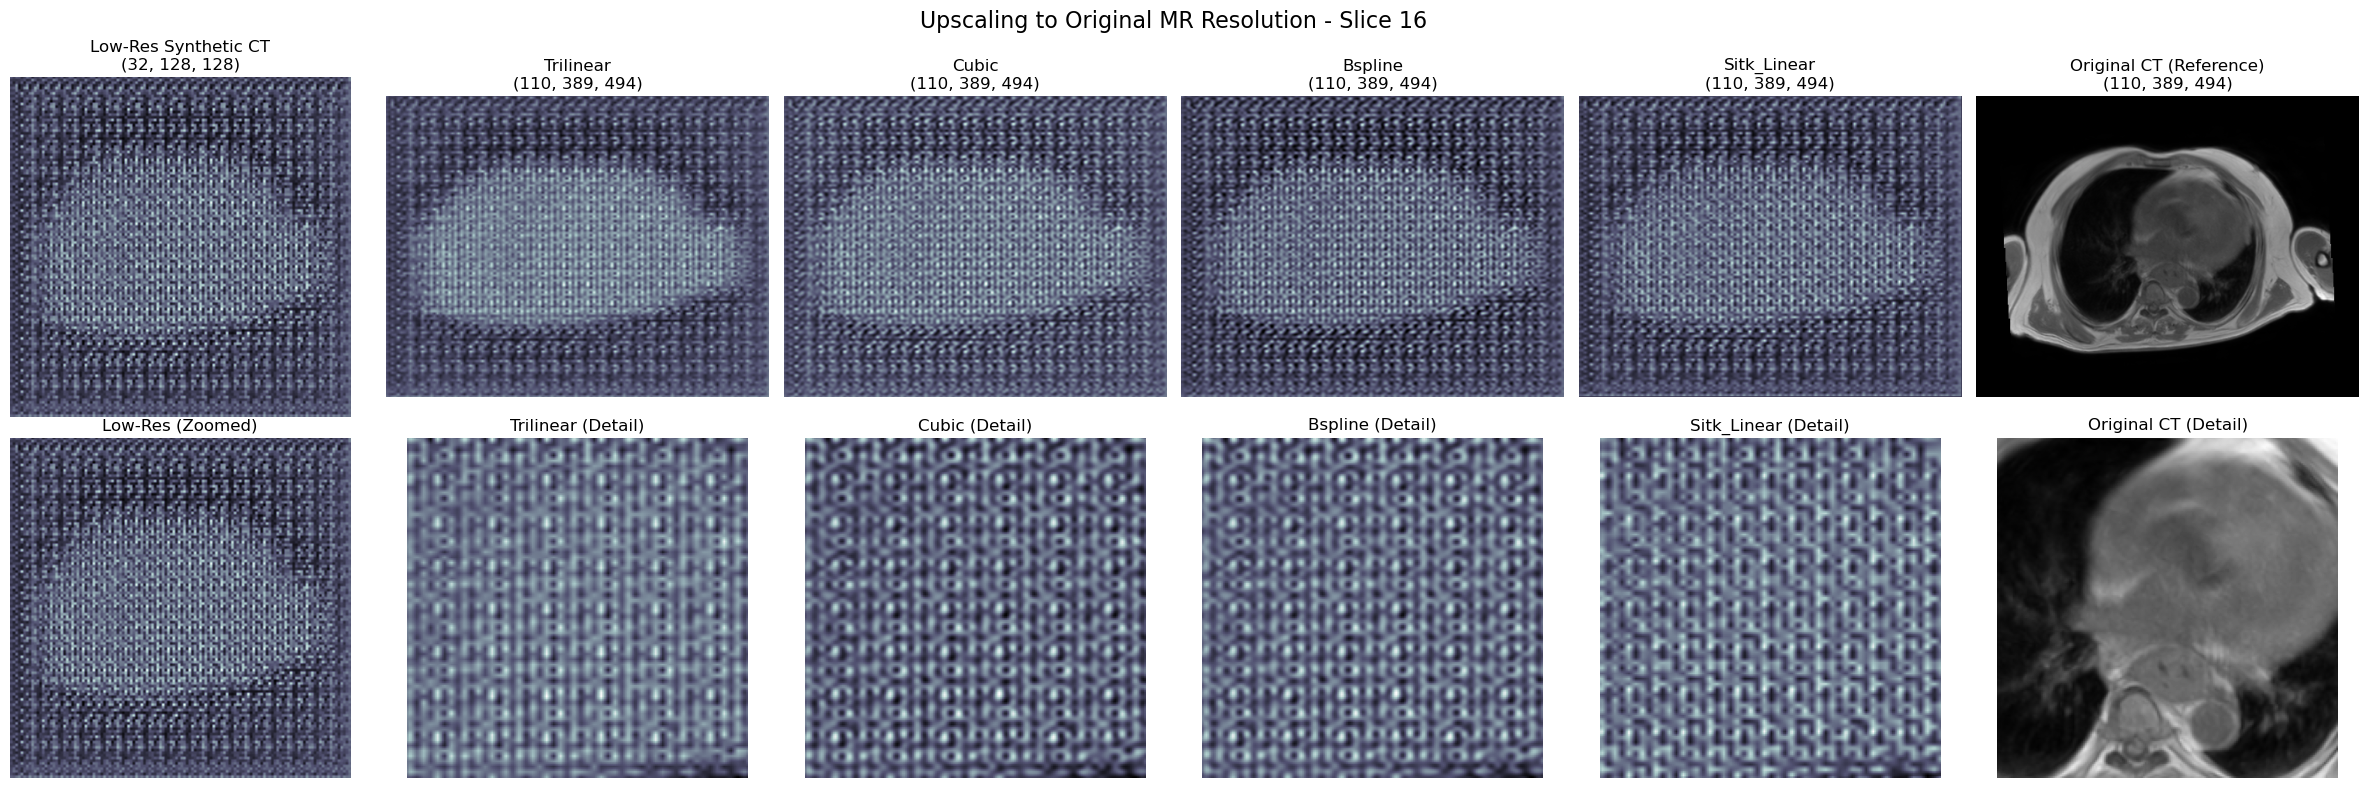

In [16]:
def compare_upscaling_methods(low_res_ct, upscaled_dict, original_mr=None, slice_idx=None):
    """Compare different upscaling methods side by side"""
    
    if slice_idx is None:
        slice_idx = low_res_ct.shape[0] // 2
    
    methods = list(upscaled_dict.keys())
    n_methods = len(methods)
    
    # Calculate scale factor for slice mapping
    first_upscaled = list(upscaled_dict.values())[0]
    scale_factor = first_upscaled.shape[0] / low_res_ct.shape[0]
    upscaled_slice_idx = int(slice_idx * scale_factor)
    
    # Determine number of columns (low-res CT + upscaled methods + optionally original MR)
    n_cols = n_methods + 1
    if original_mr is not None:
        n_cols += 1
    
    fig, axes = plt.subplots(2, n_cols, figsize=(4 * n_cols, 8))
    
    col_idx = 0
    
    # Low-resolution synthetic CT (original input)
    axes[0, col_idx].imshow(low_res_ct[slice_idx], cmap='bone')
    axes[0, col_idx].set_title(f'Low-Res Synthetic CT\n{low_res_ct.shape}')
    axes[0, col_idx].axis('off')
    
    axes[1, col_idx].imshow(low_res_ct[slice_idx], cmap='bone')
    axes[1, col_idx].set_title(f'Low-Res (Zoomed)')
    axes[1, col_idx].axis('off')
    col_idx += 1
    
    # Upscaled methods
    for method, upscaled in upscaled_dict.items():
        # Full view
        axes[0, col_idx].imshow(upscaled[upscaled_slice_idx], cmap='bone')
        axes[0, col_idx].set_title(f'{method.title()}\n{upscaled.shape}')
        axes[0, col_idx].axis('off')
        
        # Cropped view for detail comparison
        h, w = upscaled.shape[1:]
        crop_size = min(h, w) // 4
        center_h, center_w = h // 2, w // 2
        crop = upscaled[upscaled_slice_idx,
                       center_h - crop_size:center_h + crop_size,
                       center_w - crop_size:center_w + crop_size]
        
        axes[1, col_idx].imshow(crop, cmap='bone')
        axes[1, col_idx].set_title(f'{method.title()} (Detail)')
        axes[1, col_idx].axis('off')
        col_idx += 1
    
    # Original MR (if available) for reference
    if original_mr is not None:
        mr_slice_idx = upscaled_slice_idx  # Same resolution as upscaled
        axes[0, col_idx].imshow(original_mr[mr_slice_idx], cmap='gray')
        axes[0, col_idx].set_title(f'Original CT (Reference)\n{original_mr.shape}')
        axes[0, col_idx].axis('off')
        
        # Cropped view
        h, w = original_mr.shape[1:]
        crop_size = min(h, w) // 4
        center_h, center_w = h // 2, w // 2
        mr_crop = original_mr[mr_slice_idx,
                             center_h - crop_size:center_h + crop_size,
                             center_w - crop_size:center_w + crop_size]
        
        axes[1, col_idx].imshow(mr_crop, cmap='gray')
        axes[1, col_idx].set_title(f'Original CT (Detail)')
        axes[1, col_idx].axis('off')
    
    plt.suptitle(f'Upscaling to Original MR Resolution - Slice {slice_idx}', fontsize=16)
    plt.tight_layout()
    plt.show()

# Run comparison if we have results
if 'upscaled_results' in locals() and len(upscaled_results) > 0:
    print(f"📊 Comparing upscaling methods...")
    
    # Use original MR data if available for comparison
    original_mr_for_comparison = original_mr_data if 'original_mr_data' in locals() and original_mr_data is not None else None
    
    compare_upscaling_methods(ct_data, upscaled_results, original_mr_for_comparison)
    
else:
    print("❌ No upscaling results to compare. Run the upscaling cell first.")

## 💾 Save Upscaled Results

In [32]:
def save_upscaled_results(upscaled_dict, original_filename, output_dir, target_shape):
    """Save upscaled results as NPZ and NIfTI files"""
    
    base_name = os.path.splitext(os.path.basename(original_filename))[0]
    
    saved_files = []
    
    for method, upscaled_volume in upscaled_dict.items():
        
        # Save as NPZ
        npz_filename = os.path.join(output_dir, f"{base_name}_{method}_upscaled.npz")
        np.savez_compressed(npz_filename, 
                           upscaled_ct=upscaled_volume,
                           method=method,
                           target_shape=target_shape,
                           original_shape=ct_data.shape)
        
        # Save as NIfTI for medical imaging software
        nifti_filename = os.path.join(output_dir, f"{base_name}_{method}_upscaled.nii.gz")
        sitk_image = sitk.GetImageFromArray(upscaled_volume.astype(np.float32))
        sitk.WriteImage(sitk_image, nifti_filename)
        
        file_size_mb = os.path.getsize(npz_filename) / 1024 / 1024
        
        print(f"💾 {method:12}: {npz_filename}")
        print(f"   📁 NIfTI:     {nifti_filename}")
        print(f"   📊 Shape:     {upscaled_volume.shape}")
        print(f"   💽 Size:      {file_size_mb:.2f} MB")
        print()
        
        saved_files.extend([npz_filename, nifti_filename])
    
    return saved_files

# Save results if available
if 'upscaled_results' in locals() and len(upscaled_results) > 0 and len(npz_files) > 0:
    
    print(f"💾 Saving upscaled results...")
    print(f"{'='*50}")
    
    saved_files = save_upscaled_results(upscaled_results, sample_file, OUTPUT_DIR, target_shape)
    
    print(f"✅ Saved {len(saved_files)} files to: {OUTPUT_DIR}")
    print(f"\n📋 Files ready for:")
    print(f"   🔬 Medical imaging software (NIfTI files)")
    print(f"   🐍 Python analysis (NPZ files)")
    print(f"   📊 Further processing or evaluation")
    
else:
    print("❌ No results to save. Run upscaling first.")

💾 Saving upscaled results...
💾 trilinear   : ./upscaled_results/blksdf_0000_synthetic_ct_trilinear_upscaled.npz
   📁 NIfTI:     ./upscaled_results/blksdf_0000_synthetic_ct_trilinear_upscaled.nii.gz
   📊 Shape:     (118, 390, 533)
   💽 Size:      79.01 MB

💾 cubic       : ./upscaled_results/blksdf_0000_synthetic_ct_cubic_upscaled.npz
   📁 NIfTI:     ./upscaled_results/blksdf_0000_synthetic_ct_cubic_upscaled.nii.gz
   📊 Shape:     (118, 390, 533)
   💽 Size:      80.07 MB

💾 bspline     : ./upscaled_results/blksdf_0000_synthetic_ct_bspline_upscaled.npz
   📁 NIfTI:     ./upscaled_results/blksdf_0000_synthetic_ct_bspline_upscaled.nii.gz
   📊 Shape:     (118, 390, 533)
   💽 Size:      77.61 MB

💾 sitk_linear : ./upscaled_results/blksdf_0000_synthetic_ct_sitk_linear_upscaled.npz
   📁 NIfTI:     ./upscaled_results/blksdf_0000_synthetic_ct_sitk_linear_upscaled.nii.gz
   📊 Shape:     (118, 390, 533)
   💽 Size:      76.45 MB

✅ Saved 8 files to: ./upscaled_results

📋 Files ready for:
   🔬 Medical

## 🔄 Batch Processing

In [33]:
def process_all_files(method='trilinear', target_shape=None):
    """Process all NPZ files with a single upscaling method to target shape"""
    
    if target_shape is None:
        print("❌ No target shape provided. Load original MR file first.")
        return
    
    print(f"🔄 Batch processing {len(npz_files)} files with {method} to shape {target_shape}...")
    print(f"{'='*70}")
    
    batch_output_dir = os.path.join(OUTPUT_DIR, f"batch_{method}_upscaled")
    os.makedirs(batch_output_dir, exist_ok=True)
    
    total_start_time = time.time()
    
    for i, npz_file in enumerate(npz_files):
        print(f"\n📂 Processing {i+1}/{len(npz_files)}: {os.path.basename(npz_file)}")
        
        # Load data
        data = np.load(npz_file)
        if 'synthetic_ct' in data.keys():
            volume = data['synthetic_ct']
        elif 'fake_B' in data.keys():
            volume = data['fake_B']
        else:
            print(f"   ⚠️ No CT data found, skipping...")
            continue
        
        # Apply upscaling
        if method == 'trilinear':
            upscaled = upscale_to_target_trilinear(volume, target_shape)
        elif method == 'cubic':
            upscaled = upscale_to_target_cubic(volume, target_shape)
        elif method == 'bspline':
            upscaled = upscale_to_target_bspline(volume, target_shape)
        elif method == 'sitk_linear':
            upscaled = upscale_to_target_sitk_linear(volume, target_shape)
        else:
            print(f"   ❌ Unknown method: {method}")
            continue
        
        # Save result
        base_name = os.path.splitext(os.path.basename(npz_file))[0]
        
        # NPZ file
        output_npz = os.path.join(batch_output_dir, f"{base_name}_{method}_upscaled.npz")
        np.savez_compressed(output_npz, 
                           upscaled_ct=upscaled,
                           method=method,
                           target_shape=target_shape,
                           original_shape=volume.shape)
        
        # NIfTI file
        output_nii = os.path.join(batch_output_dir, f"{base_name}_{method}_upscaled.nii.gz")
        sitk_image = sitk.GetImageFromArray(upscaled.astype(np.float32))
        sitk.WriteImage(sitk_image, output_nii)
        
        print(f"   ✅ Saved: {os.path.basename(output_npz)}")
    
    total_elapsed = time.time() - total_start_time
    print(f"\n🎉 Batch processing completed!")
    print(f"   ⏱️ Total time: {total_elapsed:.2f}s")
    print(f"   📁 Output: {batch_output_dir}")
    print(f"   📊 Processed: {len(npz_files)} files")

# Example: Process all files with trilinear interpolation
print("📋 Batch processing options:")
if 'target_shape' in locals() and target_shape is not None:
    print(f"   process_all_files('trilinear', {target_shape})    # Fast, good quality")
    print(f"   process_all_files('cubic', {target_shape})        # Slower, better quality")
    print(f"   process_all_files('bspline', {target_shape})      # High quality")
    print(f"   process_all_files('sitk_linear', {target_shape})  # Medical imaging optimized")
    print(f"\n   # Uncomment to run batch processing:")
    print(f"   # process_all_files('trilinear', {target_shape})")
else:
    print("   ⚠️ Load original MR file first to get target shape")
    print("   process_all_files('trilinear', target_shape)")
    print("   process_all_files('cubic', target_shape)")
    print("   process_all_files('bspline', target_shape)")
    print("   process_all_files('sitk_linear', target_shape)")

📋 Batch processing options:
   process_all_files('trilinear', (118, 390, 533))    # Fast, good quality
   process_all_files('cubic', (118, 390, 533))        # Slower, better quality
   process_all_files('bspline', (118, 390, 533))      # High quality
   process_all_files('sitk_linear', (118, 390, 533))  # Medical imaging optimized

   # Uncomment to run batch processing:
   # process_all_files('trilinear', (118, 390, 533))


## 📈 Quality Assessment

In [34]:
def assess_upscaling_quality(low_res_ct, upscaled_dict, original_mr=None):
    """Basic quality assessment of upscaling methods"""
    
    print(f"📈 Quality Assessment Report")
    print(f"{'='*50}")
    
    low_res_shape = low_res_ct.shape
    
    for method, upscaled in upscaled_dict.items():
        
        # Calculate scale factors
        scale_factors = tuple(upscaled.shape[i] / low_res_shape[i] for i in range(len(low_res_shape)))
        avg_scale = np.mean(scale_factors)
        
        # Downsample upscaled version back to low-res size for comparison
        downsampled = zoom(upscaled, tuple(1.0/sf for sf in scale_factors), order=1)
        
        # Ensure same shape (might have rounding differences)
        if downsampled.shape != low_res_shape:
            downsampled = resize(downsampled, low_res_shape, preserve_range=True)
        
        # Calculate metrics against low-res CT
        mse = np.mean((low_res_ct - downsampled) ** 2)
        rmse = np.sqrt(mse)
        psnr = 20 * np.log10(np.max(low_res_ct) / rmse) if rmse > 0 else float('inf')
        
        # Value range preservation
        low_res_range = (low_res_ct.min(), low_res_ct.max())
        upscaled_range = (upscaled.min(), upscaled.max())
        range_diff = abs(low_res_range[1] - low_res_range[0]) - abs(upscaled_range[1] - upscaled_range[0])
        
        print(f"\n🔍 {method.upper()}:")
        print(f"   Scale factors: {scale_factors}")
        print(f"   Average scale: {avg_scale:.2f}x")
        print(f"   RMSE (vs low-res): {rmse:.6f}")
        print(f"   PSNR (vs low-res): {psnr:.2f} dB")
        print(f"   Low-res range: [{low_res_range[0]:.3f}, {low_res_range[1]:.3f}]")
        print(f"   Upscaled range: [{upscaled_range[0]:.3f}, {upscaled_range[1]:.3f}]")
        print(f"   Range difference: {range_diff:.6f}")
        print(f"   Memory usage: {upscaled.nbytes / 1024 / 1024:.2f} MB")
        
        # If original MR is available, compare shapes
        if original_mr is not None:
            shape_match = "✅" if upscaled.shape == original_mr.shape else "❌"
            print(f"   Shape vs original MR: {shape_match} {upscaled.shape} (MR: {original_mr.shape})")
    
    print(f"\n📊 Recommendations:")
    print(f"   • Trilinear: Fast, good for previews")
    print(f"   • Cubic: Better quality, moderate speed")
    print(f"   • B-spline: High quality, slower")
    print(f"   • SimpleITK: Medical imaging optimized")

# Run quality assessment if we have results
if 'upscaled_results' in locals() and len(upscaled_results) > 0:
    original_mr_for_qa = original_mr_data if 'original_mr_data' in locals() and original_mr_data is not None else None
    assess_upscaling_quality(ct_data, upscaled_results, original_mr_for_qa)
else:
    print("❌ No upscaling results for quality assessment. Run upscaling first.")

📈 Quality Assessment Report

🔍 TRILINEAR:
   Scale factors: (3.6875, 6.09375, 8.328125)
   Average scale: 6.04x
   RMSE (vs low-res): 23.899656
   PSNR (vs low-res): 32.62 dB
   Low-res range: [-1023.583, 1021.722]
   Upscaled range: [-1022.132, 1018.416]
   Range difference: 4.757080
   Memory usage: 93.57 MB
   Shape vs original MR: ✅ (118, 390, 533) (MR: (118, 390, 533))

🔍 CUBIC:
   Scale factors: (3.6875, 6.09375, 8.328125)
   Average scale: 6.04x
   RMSE (vs low-res): 5.849203
   PSNR (vs low-res): 44.84 dB
   Low-res range: [-1023.583, 1021.722]
   Upscaled range: [-1394.187, 1479.158]
   Range difference: -828.040039
   Memory usage: 93.57 MB
   Shape vs original MR: ✅ (118, 390, 533) (MR: (118, 390, 533))

🔍 BSPLINE:
   Scale factors: (3.6875, 6.09375, 8.328125)
   Average scale: 6.04x
   RMSE (vs low-res): 82.384018
   PSNR (vs low-res): 21.87 dB
   Low-res range: [-1023.583, 1021.722]
   Upscaled range: [-1023.583, 1021.722]
   Range difference: 0.000000
   Memory usage: 93.